In [1]:
from ovito import scene
from ovito.io import *
from ovito.vis import *
from ovito.data import *
from ovito.modifiers import *
from PySide2.QtGui import QPainter
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn import metrics
import sklearn
import seaborn as sns
import pandas as pd
import utils
from PIL import Image
import imageio
import freud
import cv2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import models
from tensorflow_graphics.nn import loss
from tensorflow_graphics.geometry import transformation
import colorsys

In [2]:
palette = sns.color_palette()
palette.insert(0, palette.pop(7))

In [3]:
def _preprocess(frame, data):
    if 'Comment' in data.attributes:
        L = float(data.attributes['Comment'])
        data.cell_.matrix = np.insert(np.eye(3) * L, 3, 0, axis=-1)
    data.cell_.pbc = (True, True, True)
    data.particles.vis.radius = 1.0

In [10]:
def baseline_compare(prefix, filename, labels):
    modifier_dict = {'AJA': AcklandJonesModifier(),
                     'CNA': CommonNeighborAnalysisModifier(),
                     'PTM': PolyhedralTemplateMatchingModifier()}

    

    def structure_id(modifier):
        pipeline = import_file(filename, columns=['Position.X', 'Position.Y', 'Position.Z'])
        pipeline.modifiers.append(_preprocess)
        pipeline.modifiers.append(modifier_dict[modifier])
        data = pipeline.compute()
        stru_type = data.particle_properties.structure_types[:]
        for i in range(len(np.bincount(stru_type))):
            modifier_dict[modifier].structures[i].color = palette[i]

        pipeline.add_to_scene()
        vp = Viewport(type = Viewport.Type.Ortho, camera_dir = (-1, -1, -1))
        vp.zoom_all(size=(1000,1000))
        vp.render_image(filename=prefix + modifier + '.png', size=(1000,1000), renderer=TachyonRenderer())
        pipeline.remove_from_scene()
        
        # plt.figure(figsize=(10, 10))
        # image = plt.imread(prefix + modifier + '.png')
        # plt.imshow(image)
        # plt.axis('off')

        # num = len(labels)
        # pd = 4/3*np.pi*num / data.cell.volume
        # ide = modifier_dict[modifier].object_title
        ars = metrics.adjusted_rand_score(stru_type, labels)
        
        # plt.title(
        # '''Particle Number: {}
        # Packing Density: {}
        # Identification : {}
        # Cluster Metrics: {}'''.format(num,pd,ide,ars),
        # fontdict={'fontsize':16})

        # plt.tight_layout()
        # plt.savefig(prefix + modifier + '.png')
        # plt.close()
        

        return ars

    cluster_metrics = {}
    for modifier in modifier_dict.keys():
        cm = structure_id(modifier)
        cluster_metrics[modifier] = cm
    return cluster_metrics

In [11]:
baseline_compare('/mnt/Edisk/kiwi/OPSI/test/', '/mnt/Edisk/kiwi/OPSI/data/sphere_packing.xyz', [1]*1728)

{'AJA': 0.0, 'CNA': 0.0, 'PTM': 0.0}

In [29]:
box, points = utils.read_xyz('/mnt/Edisk/kiwi/OPSI/data/sphere_packing.xyz')
centers, neighbors = utils.get_neighbors(box, points, 12)

In [26]:
def draw_xyz(savepath, filename, labels, probabilities):
    pipeline = import_file(filename, columns=['Particle Type', 'Position.X', 'Position.Y', 'Position.Z'])
    pipeline.modifiers.append(_preprocess)
    data = pipeline.compute()
    part_type = data.particles.particle_types[:]
    data.particles_.create_property('Color')
    for i in range(len(labels)):
        data.particles_.colors[i] = sns.desaturate(palette[labels[i]], probabilities[i])

    pipeline.add_to_scene()
    vp = Viewport(type = Viewport.Type.Ortho, camera_dir = (-1, -1, -1))
    vp.zoom_all(size=(1000,1000))
    vp.render_image(filename=savepath, size=(1000,1000), renderer=TachyonRenderer())
    pipeline.remove_from_scene()
    

In [26]:
metric = {'1':2, '4':4, '3':5}
df = pd.DataFrame(metric, index=[1])

In [27]:
df

,1,4,3
1,2,4,5


In [22]:
add = {'3':5}
df.append(add, ignore_index=True)

,1,2,3
0,2.0,4.0,NaN
1,NaN,NaN,5.0


In [66]:
prefix = 'model/' + '210416214933_AutoEncoderV2_2_12' + '/baseline/'
images = [plt.imread(prefix + modifier + '.png') for modifier in ['AJA', 'CNA', 'PTM']]
frame1 = np.concatenate(np.array(images, dtype=np.uint8), axis=-2)
images = [plt.imread('model/' + '210416214933_AutoEncoderV2_2_12' + '/packing.png')] * 3
frame2 = np.concatenate(np.array(images, dtype=np.uint8), axis=-2)

In [68]:
frame1[0]

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       ...,
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]], dtype=uint8)

In [64]:
help(imageio.mimsave)

Help on function mimwrite in module imageio.core.functions:

mimwrite(uri, ims, format=None, **kwargs)
    mimwrite(uri, ims, format=None, **kwargs)
    
    Write multiple images to the specified file.
    
    Parameters
    ----------
    uri : {str, pathlib.Path, file}
        The resource to write the images to, e.g. a filename, pathlib.Path
        or file object, see the docs for more info.
    ims : sequence of numpy arrays
        The image data. Each array must be NxM, NxMx3 or NxMx4.
    format : str
        The format to use to read the file. By default imageio selects
        the appropriate for you based on the filename and its contents.
    kwargs : ...
        Further keyword arguments are passed to the writer. See :func:`.help`
        to see what arguments are available for a particular format.



In [10]:
np.insert(points, 2, 0, 1)

array([[25.57412035, 13.84623588,  0.        ],
       [33.26012852, 33.9303698 ,  0.        ],
       [31.7500146 , 22.94128489,  0.        ],
       ...,
       [20.97901659, 25.73192557,  0.        ],
       [ 3.89853495, 23.92404991,  0.        ],
       [16.88289562,  1.08842304,  0.        ]])

In [6]:
box, points = utils.read_xyz('data/circle_packing/circle_packing_0.869740.xyz')
points_0 = np.insert(points, 2, 0, 1)
# Compute the hexatic (6-fold) order for the 2D system
hex_order = freud.order.Hexatic(k=6)
hex_order.compute(system=(box, points_0))
probabilities = [prob if prob > 0.9 else 0 for prob in np.abs(hex_order.particle_order)]

In [13]:
pipeline = import_file('/mnt/Edisk/kiwi/OPSI/model/210425214847_AutoEncoderV2_2_6/packing/circle_packing_0.835729.xyz', columns=['Position.X', 'Position.Y', 'Particle Type'])
pipeline.modifiers.append(utils.circle_preprocess)
pipeline.modifiers.append(_hexatic_order)

In [12]:
def _hexatic_order(frame, data):
    box = freud.Box.from_matrix(data.cell.matrix[:3,:3])
    points = data.particles.position[:]
    hex_order = freud.order.Hexatic(k=6)
    hex_order.compute(system=(box, points))
    label = [1 if prob > 0.9 else 0 for prob in np.abs(hex_order.particle_order)]
    data.particles_.particle_types_[:] = label

In [135]:
data = pipeline.compute()
data.particles.particle_type[:]

PropertyView([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
              0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
              0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
              0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
              0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
              1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
              1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
              0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
              0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
              0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
              0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
              0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
              0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
              0, 1, 1, 0, 1, 0, 0, 1, 

In [91]:
pipeline.add_to_scene()
vp = Viewport(type = Viewport.Type.Ortho, camera_dir = (0, 0, -1))
vp.zoom_all(size=(1000,1000))
qimage = vp.render_image(size=(1000,1000), renderer=TachyonRenderer())
pipeline.remove_from_scene()

In [16]:
Image.fromqimage(qimage)

In [175]:
palette = sns.color_palette()
palette.insert(0, [1,1,1])

In [176]:
palette

[[1, 1, 1],
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [5]:
image = Image.open('/mnt/Edisk/kiwi/OPSI/model/210425214847_AutoEncoderV2_2_6/packing/circle_packing_0.835729.png').resize((1010, 1010)).crop((5,5,1005,1005))

In [9]:
np.array(image).shape

(1000, 1000, 4)

In [37]:
palette[1]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [39]:
sns.palplot([1-0.12156862745098039 * 0.5, 1-0.4666666666666667 * 0.5, 1-0.7058823529411765 * 0.5])

In [40]:
import colorsys

In [148]:
hsv = colorsys.rgb_to_hls(*palette[5])
hsv

(0.7540983606557377, 0.5274509803921569, 0.7593360995850621)

In [153]:
rgb = colorsys.hls_to_rgb(hsv[0],0.5,hsv[2])
rgb

(0.518672199170124, 0.1203319502074689, 0.8796680497925311)

In [230]:
palette = []
for c in sns.color_palette():
    nc = colorsys.rgb_to_hls(*c)
    palette.append(colorsys.hls_to_rgb(nc[0],0.5,nc[2]))

In [231]:
for i in range(8):
    sns.palplot(palette[i])

In [237]:
palette = []
for c in sns.color_palette():
    nc = colorsys.rgb_to_hls(*c)
    palette.append(colorsys.hls_to_rgb(nc[0],0.5,nc[2]))

In [238]:
for i in range(8):
    sns.palplot(palette[i])

In [240]:
x = np.ones((32,28,28))

In [249]:
tf.reshape(x, [-1, 28, 28, 1]).shape


TensorShape([32, 28, 28, 1])

In [245]:
[0]*(13//2) + [1]*(13//2)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

In [1]:
from tensorflow_graphics.datasets.modelnet40 import ModelNet40
modelnet40 = ModelNet40()

In [4]:
modelnet40.download_and_prepare()

: 

In [2]:
modelnet40.as_dataset()

: 

In [7]:
[tf.keras.initializers.Orthogonal()((3, 3)) for _ in range(10)]

[<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[-0.62798893, -0.18631314, -0.75559074],
        [-0.73527074, -0.17604843,  0.65451044],
        [ 0.25496447, -0.96658903,  0.02643414]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[ 0.48542404, -0.7990138 ,  0.3548803 ],
        [-0.8634913 , -0.501729  ,  0.05148478],
        [ 0.1369167 , -0.331428  , -0.9334931 ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[ 0.3615433 , -0.36734053, -0.85694087],
        [-0.29712558, -0.9165874 ,  0.26755172],
        [ 0.88374376, -0.15788753,  0.44053215]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[ 0.48343801, -0.57911897, -0.6564367 ],
        [-0.87370926, -0.27292585, -0.40267062],
        [-0.05403564, -0.76820105,  0.6379242 ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[-0.67715526, -0.59016234,  0.43951008],
        [-0.45023337,  0.804735  ,  0.38689983

In [22]:
tf.broadcast_to(tf.expand_dims([1,2,3,4,5], -1), [5,5])

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5]], dtype=int32)>

In [23]:
tf.broadcast_to(tf.expand_dims([1,2,3,4,5], -2), [5,5])

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5]], dtype=int32)>

In [32]:
X_pred = np.random.rand(4,3,2)

In [33]:
X_pred

array([[[0.8419911 , 0.28862509],
        [0.54724972, 0.74305226],
        [0.03108861, 0.14226849]],

       [[0.32834696, 0.17471297],
        [0.96207601, 0.27667738],
        [0.80903025, 0.08244657]],

       [[0.17970238, 0.26354129],
        [0.98371662, 0.77372455],
        [0.46155721, 0.11007493]],

       [[0.90768913, 0.2224115 ],
        [0.81025968, 0.63846769],
        [0.00912549, 0.5843183 ]]])

In [178]:
broadcast_2 = tf.broadcast_to(tf.expand_dims(X_pred, 0), [4, 4, 3, 2]) 
broadcast_3 = tf.broadcast_to(tf.expand_dims(X_pred, 1), [4, 4, 3, 2])
distance = tf.reduce_mean(tf.square(tf.norm(broadcast_2 - broadcast_3, ord=2, axis=-1)))

In [179]:
distance

<tf.Tensor: shape=(), dtype=float64, numpy=0.2153805339039028>

In [70]:
ae = models.AutoEncoderV4(32,2,12,3)

In [83]:
ae(np.random.rand(32,12,3), training=True)

<tf.Tensor: shape=(10, 3, 3), dtype=float32, numpy=
array([[[ 0.4156562 ,  0.9041906 , -0.09833149],
        [-0.63262904,  0.3650959 ,  0.6829973 ],
        [ 0.6534602 , -0.22168478,  0.72377175]],

       [[-0.84832275,  0.29049015, -0.44267818],
        [ 0.21259867,  0.9525836 ,  0.21768379],
        [-0.48492295, -0.09055334,  0.86985624]],

       [[-0.04525089,  0.7215804 ,  0.69085   ],
        [ 0.9988658 ,  0.02242941,  0.04199922],
        [ 0.01481047,  0.6919671 , -0.7217771 ]],

       [[-0.48861372, -0.77502316, -0.4007439 ],
        [-0.3204709 ,  0.58661884, -0.74375856],
        [-0.811514  ,  0.23498392,  0.53500235]],

       [[-0.5677469 ,  0.15816297,  0.8078664 ],
        [ 0.74369323, -0.32223517,  0.5857345 ],
        [-0.35296446, -0.9333536 , -0.06532325]],

       [[ 0.3474754 ,  0.9119017 , -0.21839386],
        [-0.90408784,  0.3876006 ,  0.17997484],
        [ 0.24876897,  0.13491039,  0.95912105]],

       [[ 0.2328341 , -0.07723062,  0.969445  ],
     

In [129]:
# 实际的线
TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

# 随机向量x
x = tf.random.normal(shape=[NUM_EXAMPLES])

# 生成噪声
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# 计算y
y = x * TRUE_W + TRUE_B + noise

In [130]:
# 绘制所有的数据
import matplotlib.pyplot as plt

plt.scatter(x, y, c="b")
plt.show()

In [146]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # 初始化权重为`5.0`，偏差为`0.0`
    # 实际中应该随机初始化该值
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def call(self, x, **kwargs):
    print(tf.keras.initializers.Orthogonal()((3,3)))
    return self.w * x + self.b

keras_model = MyModelKeras()

In [147]:
keras_model.compile(
    # 默认情况下，fit()调用tf.function()。
    # Debug时你可以关闭这一功能，但是现在是打开的。
    run_eagerly=True,

    # 使用内置的优化器，配置为对象
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras内置MSE
    # 您也可以使用损失函数像上面一样进行定义
    loss=tf.keras.losses.mean_squared_error,
)

In [148]:
keras_model.fit(x, y, epochs=10, batch_size=1000)

Epoch 1/10
tf.Tensor(
[[ 0.01906681 -0.9135916  -0.40618575]
 [ 0.9918239   0.06855494 -0.10763636]
 [ 0.1261817  -0.40081242  0.9074291 ]], shape=(3, 3), dtype=float32)
1/1 [==============================] - 0s 6ms/step - loss: 8.6940
Epoch 2/10
tf.Tensor(
[[ 0.80194175 -0.4912585  -0.33993295]
 [-0.52536374 -0.850821   -0.00981976]
 [-0.28439808  0.18646333 -0.9403984 ]], shape=(3, 3), dtype=float32)
1/1 [==============================] - 0s 4ms/step - loss: 6.0270
Epoch 3/10
tf.Tensor(
[[ 0.04316306 -0.8662442   0.49775317]
 [-0.6681312   0.34538847  0.6590202 ]
 [-0.7427905  -0.36100966 -0.5638567 ]], shape=(3, 3), dtype=float32)
1/1 [==============================] - 0s 4ms/step - loss: 4.2914
Epoch 4/10
tf.Tensor(
[[-0.33416831 -0.12261733 -0.9345033 ]
 [-0.9401862   0.11299899  0.32137382]
 [-0.06619192 -0.9860001   0.15304378]], shape=(3, 3), dtype=float32)
1/1 [==============================] - 0s 4ms/step - loss: 3.1617
Epoch 5/10
tf.Tensor(
[[ 0.7579582  -0.15756154  0.63298

In [95]:
geodesic_distance = tf.function(lambda R1, R2: 1/np.pi * tf.math.acos((tf.linalg.trace(tf.linalg.matmul(R1, R2, transpose_b=True)) - 1)/2))

In [96]:
R1 = [tf.keras.initializers.Orthogonal()((3,3)) for _ in range(10)]
R2 = [tf.keras.initializers.Orthogonal()((3,3)) for _ in range(10)]

In [158]:
tf.linalg.trace(R1[3])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.1864337>

In [161]:
R1[3]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.63271666, -0.68827546,  0.35488942],
       [-0.65230674, -0.22672865,  0.7232497 ],
       [-0.4173314 , -0.68910885, -0.5924217 ]], dtype=float32)>

In [167]:
tf.eigvals(R1[3])

<tf.Tensor: shape=(3,), dtype=complex64, numpy=
array([-0.5932166+8.0504268e-01j, -0.5932167-8.0504256e-01j,
        0.9999999+9.9064490e-09j], dtype=complex64)>

In [97]:
geodesic_distance(R1, R2)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.5105808 , 0.6294418 , 0.91530216, 0.6550823 , 0.69519174,
       0.35526636, 0.61196303, 0.78788984, 0.84483874, 0.5536349 ],
      dtype=float32)>

In [98]:
tf.linalg.matmul(R1[-1], R2[-1], transpose_b=True)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.22907534,  0.89437497, -0.38421068],
       [ 0.81404096, -0.3924361 , -0.428172  ],
       [ 0.53372467,  0.21467952,  0.8179552 ]], dtype=float32)>

In [99]:
tf.linalg.trace(tf.linalg.matmul(R1[-1], R2[-1], transpose_b=True))

<tf.Tensor: shape=(), dtype=float32, numpy=0.6545944>

In [100]:
tf.linalg.det(tf.linalg.matmul(R1[1], R2[1], transpose_b=True))

<tf.Tensor: shape=(), dtype=float32, numpy=-1.0>

In [110]:
a = tf.constant(np.arange(1, 13, dtype=np.int32), shape=[2, 2, 3])
b = tf.constant(np.arange(13, 25, dtype=np.int32), shape=[2, 3, 2])
b = tf.broadcast_to(tf.expand_dims(b, axis=1), [2,4,3,2])
c = tf.matmul(a, b)
c  # `a` * `b`

: 

In [129]:
dataset = tf.data.Dataset.from_tensor_slices([1.,2.,3.])
# dataset = dataset.shuffle(3)
dataset = dataset.map(lambda x: ((x, [tf.keras.initializers.Orthogonal()((3, 3)) for _ in range(10)]), x))

In [136]:
list(dataset.as_numpy_iterator())

[((1.0,
   array([[[-0.5945418 , -0.37904075, -0.7091177 ],
           [ 0.7921862 , -0.12509906, -0.59731996],
           [-0.13769865,  0.9168851 , -0.3746475 ]],
   
          [[ 0.0792408 ,  0.46109754,  0.8838043 ],
           [ 0.5025467 , -0.7841625 ,  0.3640549 ],
           [-0.860911  , -0.4153049 ,  0.29386067]],
   
          [[-0.35722947,  0.5982628 , -0.71726465],
           [-0.46045086, -0.7809367 , -0.42204607],
           [-0.8126328 ,  0.17949785,  0.5544443 ]],
   
          [[ 0.6281873 , -0.53044933,  0.56921375],
           [-0.681418  , -0.02194574,  0.7315654 ],
           [ 0.37556657,  0.84743255,  0.37524372]],
   
          [[-0.39237678,  0.5768401 , -0.7164466 ],
           [-0.65222853,  0.37473217,  0.65891856],
           [-0.64856625, -0.7258314 , -0.22919527]],
   
          [[ 0.7841791 ,  0.6104859 , -0.11122178],
           [ 0.5683744 , -0.7785606 , -0.26607144],
           [-0.24902575,  0.14543203, -0.95751536]],
   
          [[-0.73815334, -

In [3]:
@tf.function
def geodesic_distance(R1, R2):
    matmuled = tf.matmul(R1, R2, transpose_b=True)
    traced = tf.linalg.trace(matmuled)
    cosval = tf.clip_by_value((traced - 1) / 2, -1, 1)
    return tf.math.acos(cosval) / np.pi

In [52]:
a = [tf.keras.initializers.Orthogonal()((3, 3)) for _ in range(100)]
b = [tf.keras.initializers.Orthogonal()((3, 3)) for _ in range(100)]
mul = tf.matmul(a, b, transpose_a=True)
geodesic_distance(mul, mul)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.01006109, 0.01005869, 0.01006109, 0.0100623 , 0.0100635 ,
       0.01005869, 0.0100635 , 0.0100659 , 0.01006109, 0.0100659 ,
       0.0100659 , 0.0100635 , 0.0100635 , 0.0100635 , 0.0100635 ,
       0.0100623 , 0.0100635 , 0.01006109, 0.01006109, 0.0100623 ,
       0.0100635 , 0.0100635 , 0.0100635 , 0.0100635 , 0.0100635 ,
       0.0100647 , 0.0100623 , 0.0100635 , 0.0100647 , 0.01006109,
       0.01006109, 0.0100659 , 0.01006109, 0.01006109, 0.0100635 ,
       0.0100647 , 0.01006109, 0.01006109, 0.0100635 , 0.01005989,
       0.0100635 , 0.0100647 , 0.0100635 , 0.0100659 , 0.0100635 ,
       0.0100647 , 0.0100635 , 0.0100635 , 0.0100635 , 0.0100635 ,
       0.0100647 , 0.0100635 , 0.0100623 , 0.0100635 , 0.0100647 ,
       0.01006109, 0.0100635 , 0.0100659 , 0.0100647 , 0.0100635 ,
       0.0100635 , 0.0100635 , 0.0100635 , 0.0100635 , 0.0100635 ,
       0.0100635 , 0.0100647 , 0.0100635 , 0.0100647 , 0.0100623 ,
       0.01006

In [11]:
tf.matmul(a[0], [[1],[1],[1]])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-0.4768517 ],
       [-1.6002616 ],
       [ 0.46019095]], dtype=float32)>

In [12]:
tf.clip_by_value([2,3,2,1,3,1.111,-1.0001],-1,1)

<tf.Tensor: shape=(7,), dtype=float32, numpy=array([ 1.,  1.,  1.,  1.,  1.,  1., -1.], dtype=float32)>

In [23]:
a = np.array([[1.,2.,3.],[4.,5.,6.]])
b = tf.keras.initializers.Orthogonal()((3, 3))

In [24]:
a @ b

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.902581  , -2.1823962 , -0.90120465],
       [-5.4029875 , -6.4718943 , -2.43358   ]], dtype=float32)>

In [25]:
a[:1] @ b

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-2.902581  , -2.1823962 , -0.90120465]], dtype=float32)>

In [26]:
tf.norm(a[0])

<tf.Tensor: shape=(), dtype=float64, numpy=3.7416573867739413>

In [27]:
tf.norm(a[:1] @ b)

<tf.Tensor: shape=(), dtype=float32, numpy=3.7416575>

In [8]:
a = np.random.rand(5,3)
a

array([[0.75446103, 0.73939338, 0.2019619 ],
       [0.70538133, 0.71836418, 0.08928114],
       [0.56308745, 0.96189537, 0.12720687],
       [0.48979381, 0.99353033, 0.27837151],
       [0.51721861, 0.96338903, 0.92329821]])

In [9]:
tf.square(tf.norm(a, ord=2, axis=-1))

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([1.15670263, 1.02158104, 1.25849176, 1.3044912 , 2.04811309])>

In [22]:
tf.math.acos(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=1.5707964>

In [38]:
@tf.function
def geodesic_distance(R1, R2):
    matmuled = tf.matmul(R1, R2, transpose_b=True)
    traced = tf.linalg.trace(matmuled)
    cosval = (traced - 1) / 2
    return 1 - cosval
    return tf.math.acos(cosval) / np.pi

In [73]:
a = [tf.keras.initializers.Orthogonal()((3, 3)) for _ in range(100)]
b = [tf.keras.initializers.Orthogonal()((3, 3)) for _ in range(100)]
mul = tf.matmul(a, b, transpose_a=True)
tf.reduce_mean(geodesic_distance(mul[0], mul[1]))

<tf.Tensor: shape=(), dtype=float32, numpy=1.9294143>

In [4]:
y = transformation.quaternion.rotate(decoded, normed)
y

<tf.Tensor: shape=(12, 3), dtype=float32, numpy=
array([[1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ],
       [1.5999999, 6.2      , 6.       ]], dtype=float32)>

In [5]:
transformation.rotation_matrix_3d.rotate(decoded, transformation.rotation_matrix_3d.from_quaternion(normed))

<tf.Tensor: shape=(12, 3), dtype=float32, numpy=
array([[1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ],
       [1.5999994, 6.2      , 6.       ]], dtype=float32)>

In [11]:
mat = transformation.rotation_matrix_3d.from_quaternion(normed)
mat

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.13333333, -0.6666667 ,  0.7333333 ],
       [ 0.93333334,  0.3333333 ,  0.13333336],
       [-0.3333333 ,  0.6666666 ,  0.6666667 ]], dtype=float32)>

In [3]:
history = pd.read_csv('model/' + '210513211608_3958299_AutoEncoderV4_sphere_packing_0.701597.xyz' + '/training/logging.csv')
plt.plot(history)
# plt.plot(history['val_loss'])
# plt.legend(['loss', 'val_loss'])
plt.title("Train History")
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

In [9]:
history.drop(columns=['epoch'])

,chamfer_loss,cross_rotational_consistency_loss,hausdorff_loss,loss,rotation_loss
0,2.123274,2.010127,1.551993,39.674221,1.487936
1,1.501992,1.292783,1.366839,32.040276,1.436072
2,1.173320,1.097338,1.213957,27.734823,1.369032
3,0.899157,0.949048,1.049896,24.224577,1.323406
4,0.789582,0.821897,0.990932,22.584595,1.287595
...,...,...,...,...,...
990,0.266787,0.093964,0.532587,10.738895,0.744447
991,0.274555,0.114908,0.539342,10.993043,0.759324
992,0.271714,0.103616,0.536774,11.011660,0.765413
993,0.274271,0.112476,0.535437,11.025263,0.763464


In [12]:
history.drop(columns=['epoch', 'loss']).plot()

<AxesSubplot:>

In [5]:
centers, neighbors, pack_list = utils.read_packing('data/sphere_packing_0.701597.xyz', 12)
DIMEN_SIZE = centers.shape[1]

In [3]:
import json
with open('model/210513235802_4004444_AutoEncoderV4_sphere_packing_0.701597.xyz/training/arguments.json') as f:
    args_dict = json.load(f)

MODEL_NAME = args_dict['model_name']
DATASET = args_dict['dataset']
LATENT_DIM = args_dict['latent_dim']
CLOUD_SIZE = args_dict['cloud_size']
BATCH_SIZE = args_dict['batch_size']
REPEAT_SIZE = args_dict['repeat_size']
LEARNING_RATE = args_dict['learning_rate']

In [8]:
model = eval('models.{}({}, {}, {}, {}, {})'.format(MODEL_NAME, REPEAT_SIZE, BATCH_SIZE, LATENT_DIM, CLOUD_SIZE, DIMEN_SIZE))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=models.loss_fun)

In [10]:
checkpoint = tf.train.Checkpoint(model)
save_path = tf.train.latest_checkpoint('model/210513235802_4004444_AutoEncoderV4_sphere_packing_0.701597.xyz/training/checkpoint')
checkpoint.restore(save_path).expect_partial()

In [43]:
point_cloud = neighbors[:10]
encoded = model.encoder.predict(point_cloud)
encoded

array([[-0.15620907,  0.08966328],
       [ 0.4333004 ,  0.09956403],
       [-0.15470836,  0.11073762],
       [ 0.37685382,  0.13313279],
       [ 0.44268468,  0.09337458],
       [-0.05318618,  0.12872481],
       [ 0.34470525,  0.15234834],
       [ 0.34839717,  0.14829916],
       [-0.13832991,  0.10913594],
       [-0.15370293,  0.09868849]], dtype=float32)

In [128]:
rotmat = [tf.keras.initializers.Orthogonal()((DIMEN_SIZE, DIMEN_SIZE)) for _ in range(10)]
point_cloud_rotated = [transformation.rotation_matrix_3d.rotate(np.float32(point_cloud[0]), rm) for rm in rotmat]

In [129]:
point_cloud_rotated = tf.stack(point_cloud_rotated)

In [130]:
encoded_rot = model.encoder.predict(point_cloud_rotated)
encoded_rot

array([[-0.15405285,  0.12618053],
       [-0.1543093 ,  0.0946373 ],
       [-0.14439982,  0.10624734],
       [-0.164526  ,  0.09960613],
       [-0.1412723 ,  0.11123575],
       [-0.15556334,  0.12931159],
       [-0.15006419,  0.0991607 ],
       [-0.1579988 ,  0.12476647],
       [-0.15684652,  0.11789452],
       [-0.14845689,  0.13429898]], dtype=float32)

In [131]:
transfm = model.transformer.predict(point_cloud_rotated)
transfm = transformation.quaternion.normalize(transfm)
transfm

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[-0.2111473 , -0.26953465,  0.8015323 , -0.4902181 ],
       [-0.15023337, -0.23630536,  0.8711809 , -0.40327838],
       [-0.22484007, -0.2933637 ,  0.8447297 , -0.3870609 ],
       [ 0.31902575, -0.15097909,  0.7410871 , -0.5711547 ],
       [ 0.39998657, -0.13990998,  0.707411  , -0.5656904 ],
       [ 0.3300813 , -0.16761732,  0.7195699 , -0.5875116 ],
       [ 0.3556442 , -0.18303967,  0.6606416 , -0.63526875],
       [ 0.127839  , -0.24421719,  0.77676666, -0.56625855],
       [ 0.1230089 , -0.21331051,  0.77567554, -0.5811153 ],
       [-0.25957686, -0.21564552,  0.8469613 , -0.41082022]],
      dtype=float32)>

In [166]:
tf.math.l2_normalize(transfm, axis=-1)

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[-0.2111473 , -0.26953465,  0.8015323 , -0.4902181 ],
       [-0.15023337, -0.23630536,  0.8711809 , -0.40327838],
       [-0.2248401 , -0.29336372,  0.84472984, -0.38706097],
       [ 0.31902575, -0.15097909,  0.7410871 , -0.5711547 ],
       [ 0.39998657, -0.13990998,  0.707411  , -0.5656904 ],
       [ 0.3300813 , -0.16761732,  0.7195699 , -0.5875116 ],
       [ 0.3556442 , -0.18303967,  0.6606416 , -0.63526875],
       [ 0.127839  , -0.24421719,  0.77676666, -0.56625855],
       [ 0.1230089 , -0.21331051,  0.77567554, -0.5811153 ],
       [-0.2595769 , -0.21564555,  0.84696144, -0.41082028]],
      dtype=float32)>

In [132]:
pred_rotate_matrix = transformation.rotation_matrix_3d.from_quaternion(transfm)
pred_rotate_matrix

<tf.Tensor: shape=(10, 3, 3), dtype=float32, numpy=
array([[[-0.43020606,  0.8996743 , -0.07422125],
        [-0.6720283 , -0.37407458, -0.6390979 ],
        [-0.6027443 , -0.22506501,  0.7655358 ]],

       [[-0.62959266,  0.77365875, -0.0711672 ],
        [-0.631655  , -0.5630524 , -0.53290117],
        [-0.45235458, -0.29055768,  0.84317946]],

       [[-0.59926116,  0.7858435 , -0.15275896],
        [-0.5220039 , -0.5282428 , -0.66967964],
        [-0.60695744, -0.32157245,  0.7267694 ]],

       [[-0.14400947,  0.75021833,  0.64531654],
        [-0.9428832 , -0.301975  ,  0.14064884],
        [ 0.3003869 , -0.58820343,  0.75085574]],

       [[-0.04001021,  0.688427  ,  0.72420126],
        [-0.91227543, -0.32083905,  0.25458938],
        [ 0.40761834, -0.65048486,  0.6408719 ]],

       [[-0.09175289,  0.73485667,  0.6719874 ],
        [-0.9561661 , -0.2534691 ,  0.14662844],
        [ 0.2780789 , -0.629078  ,  0.7259015 ]],

       [[ 0.06009829,  0.70917594,  0.7024655 ],
     

In [133]:
true_rotate_matrix = tf.stack(rotmat)
true_rotate_matrix

<tf.Tensor: shape=(10, 3, 3), dtype=float32, numpy=
array([[[-0.19775152,  0.614686  , -0.7635808 ],
        [ 0.9476262 , -0.0794208 , -0.30934942],
        [-0.25079697, -0.78476334, -0.5667869 ]],

       [[-0.4495622 , -0.34094808, -0.8256198 ],
        [ 0.8661701 , -0.3922512 , -0.30965835],
        [ 0.21827294,  0.85433793, -0.47166038]],

       [[ 0.62462497,  0.18506786,  0.75867885],
        [-0.77441174,  0.02157979,  0.63231385],
        [ 0.10064886, -0.9824888 ,  0.15679795]],

       [[ 0.08770466,  0.70954585, -0.69918   ],
        [-0.7776047 , -0.38992262, -0.4932457 ],
        [ 0.62260646, -0.58694565, -0.5175481 ]],

       [[-0.38692248,  0.21449153, -0.896819  ],
        [-0.9155162 , -0.2054779 ,  0.34584516],
        [ 0.11009561, -0.9548676 , -0.27587456]],

       [[ 0.33319223,  0.5202243 , -0.78635204],
        [-0.82658875, -0.24004567, -0.50904727],
        [-0.45357922,  0.8196003 ,  0.35003027]],

       [[ 0.96873915,  0.15270802,  0.19551189],
     

In [155]:
matmuled = tf.matmul(true_rotate_matrix, pred_rotate_matrix, transpose_a=True)
matmuled

<tf.Tensor: shape=(10, 3, 3), dtype=float32, numpy=
array([[[-0.40059125, -0.4759492 , -0.78294265],
        [ 0.26194298,  0.7593492 , -0.5956295 ],
        [ 0.87801623, -0.44369036, -0.17951715]],

       [[-0.36281633, -0.8989278 , -0.24554572],
        [ 0.07596216, -0.29115394,  0.95365566],
        [ 0.92875916, -0.32734954, -0.17392   ]],

       [[-0.0311571 ,  0.86756897,  0.49633926],
        [ 0.4741602 ,  0.44997633, -0.7567651 ],
        [-0.87988675,  0.2117657 , -0.42538676]],

       [[ 0.90758294, -0.06560442,  0.4147157 ],
        [ 0.08915938,  0.99530464, -0.03767201],
        [ 0.41029698, -0.07116622, -0.90917087]],

       [[ 0.8955608 , -0.04425005, -0.4427333 ],
        [-0.21035096,  0.834714  , -0.5089252 ],
        [-0.39207563, -0.5489028 , -0.73822916]],

       [[ 0.633654  ,  0.73969996, -0.22655424],
        [ 0.409705  , -0.07245803,  0.90933573],
        [ 0.65621984, -0.66902465, -0.34897196]],

       [[ 0.04113716,  0.5135685 ,  0.8570621 ],
     

In [156]:
def geodesic_distance(R1, R2):
    matmuled = tf.matmul(R1, R2, transpose_b=True)
    traced = tf.linalg.trace(matmuled)
    cosval = (traced - 1) / 4
    return tf.math.acos(cosval) / np.pi - 1/3

rot_loss_list = []
for i in range(10):
    for j in range(i+1, 10):
        rot_loss_list.append(geodesic_distance(matmuled[i], matmuled[j]))

tf.reduce_mean(rot_loss_list)

<tf.Tensor: shape=(), dtype=float32, numpy=0.23855862>

In [161]:
transformation.rotation_matrix_3d.rotate(np.float32(point_cloud[0][0]), rotmat[0])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.8903043 ,  0.26530886, -0.59901744], dtype=float32)>

In [162]:
rotmat[0] @ np.expand_dims(np.float32(point_cloud[0][0]), axis=-1)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[-1.8903043 ],
       [ 0.26530886],
       [-0.59901744]], dtype=float32)>

In [175]:
tf.transpose(rotmat[0]) @ rotmat[1]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.85496485, -0.51854986, -0.01188176],
       [-0.5164241 , -0.8488762 , -0.11276186],
       [-0.04838639, -0.10254344,  0.993551  ]], dtype=float32)>

In [171]:
tf.matmul(rotmat[0], rotmat[1], transpose_a=True)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.85496485, -0.51854986, -0.01188176],
       [-0.5164241 , -0.8488762 , -0.11276186],
       [-0.04838639, -0.10254344,  0.993551  ]], dtype=float32)>

In [14]:
data = np.random.rand(1000,2)

In [15]:
from sklearn.manifold import TSNE

data_rd = TSNE().fit_transform(data)

In [16]:
plt.scatter(data[:,0], data[:,1])

In [17]:
plt.scatter(data_rd[:,0], data_rd[:,1])

In [5]:
q = [1.,2.,3.,4.]

In [7]:
normed = transformation.quaternion.normalize(q)

In [9]:
inversed = transformation.quaternion.inverse(normed)
inversed

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.18257418, -0.36514837, -0.5477226 ,  0.73029673], dtype=float32)>

In [14]:
1 - tf.norm(transformation.quaternion.multiply(normed, inversed))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [6]:
sklearn.utils.class_weight.compute_sample_weight('balanced', [1,2,3,4,5,5,1,1,1,1])

array([0.4, 2. , 2. , 2. , 1. , 1. , 0.4, 0.4, 0.4, 0.4])

In [2]:
tf.reduce_mean(np.random.rand(4,5,6), axis=0)

<tf.Tensor: shape=(5, 6), dtype=float64, numpy=
array([[0.61607574, 0.43225841, 0.53284655, 0.58754514, 0.48731951,
        0.33805758],
       [0.57688982, 0.50812212, 0.29556987, 0.75563943, 0.47052876,
        0.37304218],
       [0.45973993, 0.63844101, 0.66406324, 0.36961323, 0.6317879 ,
        0.49982191],
       [0.4637106 , 0.50504777, 0.58403679, 0.54973829, 0.74858644,
        0.52147988],
       [0.358134  , 0.56931062, 0.74635764, 0.44291717, 0.66613455,
        0.50805222]])>

In [2]:
data = np.load('data/lj-r2.0_scaled_shuffled_equal_samples.npy')

In [6]:
pc_size = []
for d in data:
    for i in range(len(d)):
        if np.linalg.norm(d[i]) == 0:
            pc_size.append(i)
            break

In [14]:
min(pc_size)

19

In [13]:
len(pc_size)

536246

In [11]:
len(data)

540000

In [12]:
540000 - 536246

3754

In [ ]:
pc_size = []
for d in data:
    for i in range(len(d)):
        if np.linalg.norm(d[i]) == 0:
            pc_size.append(i)
            break

In [39]:
np.linalg.norm(data[9], axis=-1)

array([1.        , 1.06326501, 1.06722859, 1.10277126, 1.12455838,
       1.13645729, 1.15660067, 1.16760593, 1.18453075, 1.20806885,
       1.22623909, 1.35337244, 1.39498484, 1.40529387, 1.42315147,
       1.44295809, 1.59190581, 1.62933195, 1.73082845, 1.73303478,
       1.7620674 , 1.76465152, 1.8013583 , 1.80426783, 1.81256905,
       1.84781106, 1.85082757, 1.86329439, 1.8864135 , 1.91601398,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [13]:
new_data = []
for pc in data:
    new_data.append(pc[:12])

In [14]:
np.save('data/DeFever_540k_cs12.npy', np.array(new_data))

In [12]:
np.array(new_data)

array([[[ 0.4320384 , -0.16950789, -0.88578208],
        [ 0.07131734, -0.06925017,  1.06252506],
        [ 0.68113231, -0.82273341, -0.02377245],
        ...,
        [ 0.37312407,  1.65373551, -0.55916932],
        [-1.41890507, -1.07596166, -0.1550377 ],
        [-1.56153975,  0.82790134, -0.38966143]],

       [[-0.31656553, -0.81755661, -0.4810275 ],
        [ 1.00103153,  0.19298139, -0.01521036],
        [ 0.66260112, -0.45440937, -0.6863673 ],
        ...,
        [ 0.47817555, -1.43547731, -0.58654934],
        [ 0.06939725, -1.010538  , -1.36322812],
        [-0.38881471, -1.01434059,  1.30713993]],

       [[-0.30695724, -0.93472742, -0.17905839],
        [-0.19717739,  1.04557309, -0.01598736],
        [-0.92406918,  0.38795984, -0.40927632],
        ...,
        [ 0.6373626 ,  1.43886205,  0.71197026],
        [-1.07861362,  1.3066999 ,  0.58940053],
        [-0.53504352, -0.14921532,  1.77246488]],

       ...,

       [[-0.49035765,  0.51406933,  0.70376281],
        [-0

In [42]:
len(new_data)

540000

In [15]:
a = tf.constant([1,2,3])

In [16]:
a/a

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1., 1., 1.])>

In [11]:
d = data[0:10, :12]

In [13]:
d.shape

(10, 12, 3)

In [14]:
dr = np.array([d for _ in range(8)])

In [15]:
dr.shape

(8, 10, 12, 3)

In [16]:
y_true_bt = tf.broadcast_to(tf.expand_dims(dr, -2), [8, 10, 12, 12, 3])

In [7]:
data = np.load('data/DeFever_540k_cs19.npy')

In [8]:
utils.get_raduis(data[0])

0.5007067133791859

In [2]:
data = np.load('data/DeFever_540k_cs12.npy')

In [3]:
y_true = data[0:10]
y_pred = data[10:20]

In [4]:
models.symmetric_chamfer_loss(y_true, y_pred)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.49092513, 0.43785654, 0.57914636, 0.79736328, 0.45567325,
       0.54880844, 0.66349996, 0.5421077 , 0.56937469, 0.55112675])>

In [5]:
models.weighted_chamfer_loss()(y_true, y_pred) + models.weighted_chamfer_loss()(y_pred, y_true)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.49092513, 0.43785654, 0.57914636, 0.79736328, 0.45567325,
       0.54880844, 0.66349996, 0.5421077 , 0.56937469, 0.55112675])>

In [6]:
models.symmetric_hausdorff_loss(y_true, y_pred)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([1.35647473, 1.29745485, 1.61419813, 1.81960243, 1.42331416,
       1.61342042, 1.74915599, 1.82578823, 1.6321405 , 1.4844112 ])>

In [7]:
models.weighted_hausdorff_loss()(y_true, y_pred) + models.weighted_hausdorff_loss()(y_pred, y_true)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.92004948, 0.84169455, 1.3028178 , 1.65550804, 1.01313128,
       1.30156272, 1.53513216, 1.66675134, 1.33269519, 1.10924973])>

In [12]:
from itertools import permutations
list(permutations(range(1,2)))

[(1,)]

In [5]:
a = np.random.rand(2,3)
a

array([[0.20399507, 0.07356054, 0.74004309],
       [0.37227025, 0.20000972, 0.07683829]])

In [9]:
np.delete(a, 2, -1)

array([[0.20399507, 0.07356054],
       [0.37227025, 0.20000972]])

In [13]:
-np.sum(a*np.log(a))

1.6259552742191024

In [5]:
import itertools
list(itertools.combinations(range(1), 2))

[]

In [9]:
a = np.random.rand(4,3)
a

array([[0.3517719 , 0.35576785, 0.83047158],
       [0.6495205 , 0.27537732, 0.25813887],
       [0.05639415, 0.12850243, 0.13772801],
       [0.66461114, 0.06000244, 0.26408243]])

In [12]:
tf.reduce_sum(tf.square(a), axis=-1)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.93999728, 0.56434523, 0.03866218, 0.51504779])>

In [11]:
tf.square(tf.norm(a, axis=-1))

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.93999728, 0.56434523, 0.03866218, 0.51504779])>

In [14]:
a = np.random.rand(10)
a

array([0.69260859, 0.52048991, 0.4250962 , 0.36663241, 0.2775772 ,
       0.24118996, 0.64159466, 0.07080538, 0.22191083, 0.85050562])

In [15]:
0.5 - tf.minimum(a, 0.5) # mindis < 2*radius

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.        , 0.        , 0.0749038 , 0.13336759, 0.2224228 ,
       0.25881004, 0.        , 0.42919462, 0.27808917, 0.        ])>

In [17]:
tf.nn.relu(0.5 - a)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.        , 0.        , 0.0749038 , 0.13336759, 0.2224228 ,
       0.25881004, 0.        , 0.42919462, 0.27808917, 0.        ])>

In [1]:
import seaborn as sns
import colorsys

In [27]:
palette = []
for c in sns.color_palette('Set1', n_colors=6):
    nc = colorsys.rgb_to_hls(*c)
    palette.append(colorsys.hls_to_rgb(nc[0],0.75,1))

palette.insert(0, colorsys.hls_to_rgb(0,0.75,0))

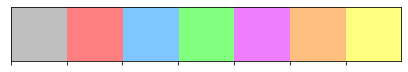

In [28]:
sns.palplot(palette)

In [3]:
sns.color_palette('Set1', n_colors=6)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2)]

In [76]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

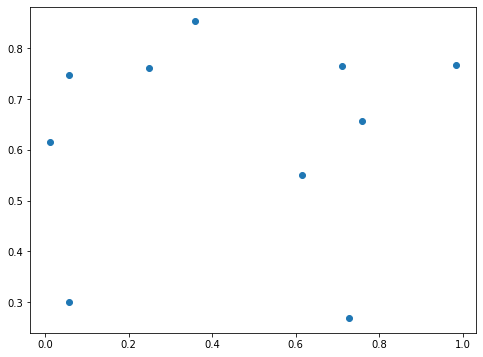

In [116]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8,6))
plt.scatter(np.random.rand(10),np.random.rand(10))
plt.savefig('test.svg')

In [46]:
palette = []
losses = [2,3,1]
for c in sns.color_palette('Set1', n_colors=6):
    nc = colorsys.rgb_to_hls(*c)
    palette.append(colorsys.hls_to_rgb(nc[0],0.5,1))
# palette.insert(0, palette.pop(7))
rule = {c: l for c, l in zip(palette, losses)}
# palette[:] = sorted(palette[:len(losses)], reverse=True, key=lambda x: rule[x])

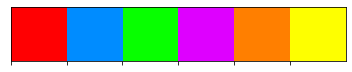

In [47]:
sns.palplot(palette)

In [48]:
palette

[(1.0, 0.0, 0.009900990099009688),
 (0.0, 0.5503875968992249, 1.0),
 (0.02970297029702973, 1.0, 0.0),
 (0.8705882352941186, 0.0, 1.0),
 (1.0, 0.4980392156862745, 0.0),
 (0.9999999999999998, 1.0, 0.0)]

In [5]:
float('212121\n')

212121.0

In [23]:
import math
def scheduler(epoch, lr):
    if epoch < 200:
        lr = lr + 0.001 / 200
    else:
        lr = lr * 0.999

    # print('Adjust learning rate: ', lr)
    return lr

In [24]:
lr = 0
lrs = [0]
for epoch in range(2000):
    lrs.append(scheduler(epoch, lrs[-1]))

In [25]:
0.996**1300 * 0.001

5.459337591624722e-06

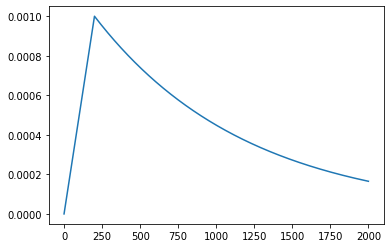

In [26]:
import matplotlib.pyplot as plt
plt.plot(lrs)

In [19]:
import freud
L = [1,2,0]

In [20]:
box = freud.Box(*L)

In [21]:
box

freud.box.Box(Lx=1.0, Ly=2.0, Lz=0.0, xy=0.0, xz=0.0, yz=0.0, is2D=True)

In [1]:
s='1  2 3'

In [2]:
s.split()

['1', '2', '3']

In [18]:
a = list(np.random.rand(10,5,5))
a

[array([[0.27030601, 0.25614955, 0.45823538, 0.71290475, 0.01112109],
        [0.03878575, 0.37695228, 0.79500222, 0.05919794, 0.27968329],
        [0.08854198, 0.31276745, 0.33115797, 0.08901661, 0.80780843],
        [0.97198586, 0.12505192, 0.30036256, 0.35085921, 0.43934229],
        [0.52831762, 0.49957075, 0.76191877, 0.17091516, 0.34436864]]),
 array([[0.67225258, 0.99000776, 0.70591259, 0.30225717, 0.18745524],
        [0.24689697, 0.30149277, 0.69977563, 0.12619215, 0.24912253],
        [0.54133736, 0.49249778, 0.86936846, 0.13151856, 0.00137224],
        [0.02106452, 0.0010923 , 0.58938474, 0.67522329, 0.33346724],
        [0.0096067 , 0.6610111 , 0.17532417, 0.82000841, 0.63927108]]),
 array([[0.86021904, 0.74921314, 0.06589313, 0.93627592, 0.46196412],
        [0.13252095, 0.26388487, 0.88424823, 0.94696518, 0.3132544 ],
        [0.50036983, 0.48316603, 0.66291352, 0.95411742, 0.30899184],
        [0.83286223, 0.91501227, 0.01122555, 0.07025352, 0.51546425],
        [0.95093

In [19]:
import random
random.sample(a,1)

[array([[0.944232  , 0.74447374, 0.39046151, 0.87139962, 0.31771757],
        [0.88184459, 0.75233537, 0.73977517, 0.92624257, 0.77334811],
        [0.51609377, 0.41781688, 0.29306506, 0.74870008, 0.96957258],
        [0.50251558, 0.71320432, 0.74269437, 0.7979094 , 0.62603614],
        [0.8851181 , 0.39832569, 0.8407545 , 0.93247637, 0.02409721]])]

In [30]:
list(reversed(np.argsort([3,2,1,4])))

TypeError: list indices must be integers or slices, not tuple

In [1]:
[1,2,3]==None

False

In [4]:
def fun(a,b=1,c):
    print(a,b)
fun(1,3,2)

SyntaxError: non-default argument follows default argument (<ipython-input-4-31a9f6d3bfec>, line 1)

In [2]:
import numpy as np
data = np.load('data/lj-r2.0_scaled_shuffled_equal_samples.npy')

In [3]:
data.shape

(540000, 43, 3)

In [4]:
low = 100
for d in data:
    for idx, row in enumerate(d):
        if np.linalg.norm(row) == 0:
            low = min(low, idx)
            break

In [5]:
low

19

In [7]:
data_19 = np.load('data/Baseline_19.npy')

In [10]:
np.min(np.linalg.norm(data_19, axis=-1))

0.9999802695072392

In [13]:
import utils
_, neighbors, pack_list = utils.read_packing('data/SP100_69_71', 12)

In [14]:
import sys
sys.getsizeof(neighbors)

28800136

In [28]:
a = [[[-1,-1,-1],
                  [-0.9,-0.9,-0.9],
                  [-0.8,-0.8,-0.8],
                  [-0.7,-0.7,-0.7],
                  [-0.6,-0.6,-0.6],
                  [-0.5,-0.5,-0.5],
                  [-0.4,-0.4,-0.4],
                  [-0.3,-0.3,-0.3],
                  [-0.2,-0.2,-0.2],
                  [-0.1,-0.1,-0.1],
                  [0.1,0.1,0.1],
                  [0.2,0.2,0.2],
                  [0.3,0.3,0.3],
                  [0.4,0.4,0.4],
                  [0.5,0.5,0.5],
                  [0.6,0.6,0.6],
                  [0.7,0.7,0.7],
                  [0.8,0.8,0.8],
                  [0.9,0.9,0.9],
                  [1,1,1]]] * 1000

In [30]:
import numpy as np
np.array(a).shape

(1000, 20, 3)

In [3]:
from scipy.spatial.transform import Rotation as R

In [19]:
transfm = [[1.,2.,3.,4.],[5.,6.,7.,8.]]

In [25]:
tf.convert_to_tensor(R.from_quat(transfm).as_quat())

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[0.18257419, 0.36514837, 0.54772256, 0.73029674],
       [0.37904902, 0.45485883, 0.53066863, 0.60647843]])>

In [21]:
transformation.quaternion.normalize(transfm)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.18257418, 0.36514837, 0.5477226 , 0.73029673],
       [0.37904903, 0.45485884, 0.5306686 , 0.60647845]], dtype=float32)>

In [10]:
losses = [3.,4.,2.,1.]

In [11]:
import colorsys
pale = []
for c in sns.color_palette('Set1', n_colors=6):
    nc = colorsys.rgb_to_hls(*c)
    pale.append(colorsys.hls_to_rgb(nc[0],0.75,1))
pale.insert(0, colorsys.hls_to_rgb(0,0.75,0))
rule = dict(zip(pale, losses))
palette = sorted(pale[:len(losses)], reverse=True, key=lambda x: rule[x])

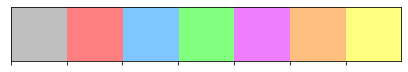

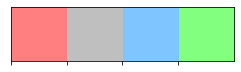

In [12]:
utils.make_palette(losses)

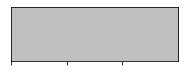

In [7]:

sns.palplot(utils.palette[0])

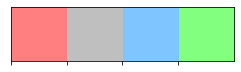

In [13]:
sns.palplot(palette)

In [1]:
if '':
    print(1)

In [4]:
import json
args = json.load(open('model/B2_0613_2320_438563_Baseline_19/training/arguments.json'))

In [6]:
args

{'model_name': 'PointNetAutoEncoder',
 'latent_dim': 3,
 'dataset': 'Baseline_19.npy',
 'batch_size': 100,
 'cloud_size': 12,
 'repeat_size': 8,
 'epochs': 10000,
 'learning_rate': 0.001,
 'crc_weight': 0.001,
 'l2_weight': 0.0,
 'dimen_size': 3,
 'radius': 0.5}

In [9]:
new_dict = {'model_name': '123',
 'latent_dim': 3,
 'dataset': '0898766.npy'}

In [10]:
new_dict

{'model_name': '123', 'latent_dim': 3, 'dataset': '0898766.npy'}

In [11]:
args.update(new_dict)

In [12]:
args

{'model_name': '123',
 'latent_dim': 3,
 'dataset': '0898766.npy',
 'batch_size': 100,
 'cloud_size': 12,
 'repeat_size': 8,
 'epochs': 10000,
 'learning_rate': 0.001,
 'crc_weight': 0.001,
 'l2_weight': 0.0,
 'dimen_size': 3,
 'radius': 0.5}

In [19]:
args.pop('dataset', 'epochs')

'0898766.npy'

In [20]:
args

{'latent_dim': 3,
 'batch_size': 100,
 'cloud_size': 12,
 'repeat_size': 8,
 'epochs': 10000,
 'learning_rate': 0.001,
 'crc_weight': 0.001,
 'l2_weight': 0.0,
 'dimen_size': 3,
 'radius': 0.5}

In [6]:
a = np.random.rand(1,6)

In [7]:
a

array([[0.08554012, 0.42091107, 0.88748567, 0.08255534, 0.05577037,
        0.81929201]])

In [8]:
np.concatenate(a, axis=0)

array([0.08554012, 0.42091107, 0.88748567, 0.08255534, 0.05577037,
       0.81929201])

In [8]:
np.array(['222'])

array(['222'], dtype='<U3')

In [3]:
pcd = utils.PointCloudDataset('data/SP100_69_71', 12)

In [5]:
pcd.make_dataset().shape

(100000, 12, 3)

In [27]:
losss = [1.1,3.3,2.2]
label_map = list(reversed(np.argsort(losss)))
print(label_map)
label_map = {j:i for i,j in enumerate(label_map)}

[1, 2, 0]


In [26]:
label_map

{1: 0, 2: 1, 0: 2}

In [ ]:
0 1 2
2 0 1

In [28]:
[0]* 10 + [1] *3

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

In [29]:
class a():
    def __len__(self):
        return 23

In [30]:
len(a())

23

In [32]:
os.path.splitext('212.121.tr')

('212.121', '.tr')

In [2]:
data = np.load('data/lj_samples.npy')

In [ ]:
for points in data:
    dis = np.linalg.norm(points, axis=-1)
    print(dis)


In [1]:
if '':
    print(3)

In [3]:
[1,2]==None

False

In [3]:
y_true = np.random.rand(10,12,3)
y_pred = np.random.rand(10,12,3)

In [4]:
loss.chamfer_distance.evaluate(y_true, y_pred)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.14030065, 0.15495637, 0.1912635 , 0.17069314, 0.11931654,
       0.14788311, 0.18886553, 0.17824148, 0.24058798, 0.21736409])>

In [5]:
import losses
losses.symmetric_chamfer_loss(y_true, y_pred)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.14030065, 0.15495637, 0.1912635 , 0.17069314, 0.11931654,
       0.14788311, 0.18886553, 0.17824148, 0.24058798, 0.21736409])>

In [6]:
losses.symmetric_hausdorff_loss(y_true, y_pred)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.28591239, 0.46694976, 0.55465704, 0.45865596, 0.33531704,
       0.41328804, 0.30213711, 0.33544743, 0.75031318, 0.5327565 ])>

In [7]:
loss.hausdorff_distance.evaluate(y_true, y_pred) + loss.hausdorff_distance.evaluate(y_pred, y_true) 

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.75618987, 0.96618428, 1.05319547, 0.95539655, 0.8121589 ,
       0.90770913, 0.77512826, 0.81354481, 1.22493922, 1.02729869])>

In [6]:
np.random.normal(-6,3,size=(10,2))

array([[ -5.64256898,  -6.48953795],
       [ -2.3835429 ,  -0.60156317],
       [ -5.32948813,  -7.10363295],
       [ -3.0262191 ,  -3.97890275],
       [ -7.8153888 ,  -1.48666291],
       [ -6.05512841,  -6.59135752],
       [ -3.48088891,  -1.19732931],
       [ -2.75771708,  -5.09719776],
       [ -4.37747823, -10.47392777],
       [ -8.83496847,  -8.44326701]])

In [ ]:
from sklearn.tree import Random

In [12]:
a = np.random.rand(10,10)
a = {1:'a', 2:'3'}

In [11]:
list(a)

[array([0.95846327, 0.60834231, 0.02414891, 0.87073514, 0.80347294,
        0.80952871, 0.43862306, 0.72988835, 0.98144495, 0.48621952]),
 array([0.28869209, 0.53898399, 0.72367009, 0.54590931, 0.8692133 ,
        0.40689658, 0.39412056, 0.61688827, 0.403505  , 0.38759588]),
 array([0.046574  , 0.46038441, 0.32448171, 0.97495625, 0.9768633 ,
        0.63935229, 0.61984925, 0.73140288, 0.42235972, 0.42260562]),
 array([0.79269298, 0.02932133, 0.55804916, 0.36980648, 0.86837873,
        0.65877931, 0.53624827, 0.83291901, 0.94009779, 0.14231361]),
 array([0.45689333, 0.25762634, 0.66281681, 0.98349225, 0.35209587,
        0.19828963, 0.10871062, 0.41198111, 0.68901866, 0.90427624]),
 array([0.64960682, 0.99696049, 0.68121435, 0.28790984, 0.59813949,
        0.29584912, 0.29280573, 0.05810276, 0.82359631, 0.46142209]),
 array([0.2313639 , 0.19015557, 0.96907403, 0.31859936, 0.87076073,
        0.09521842, 0.7910546 , 0.67496446, 0.49343291, 0.00558939]),
 array([0.81470173, 0.72329435, 0.

In [15]:
palette = []
for c in sns.color_palette('Set2', n_colors=6):
    nc = colorsys.rgb_to_hls(*c)
    palette.append(colorsys.hls_to_rgb(nc[0],0.75,1))
palette.insert(0, colorsys.hls_to_rgb(0,0.75,0))

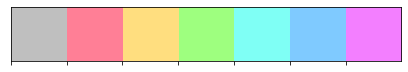

In [14]:
sns.palplot(palette)

In [21]:
palette = []
for c in sns.color_palette('Set1', n_colors=6):
    nc = colorsys.rgb_to_hls(*c)
    palette.append(colorsys.hls_to_rgb(nc[0],0.75,1))
palette.insert(0, colorsys.hls_to_rgb(0,0.75,0))

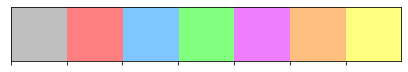

In [22]:
sns.palplot(palette)